In [174]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import plotly.offline as pyo
import seaborn as sns

#for web scraping
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re

# Finding what type of valorant role is my best

In [175]:
df = pd.read_excel('./valo.xlsx', sheet_name='mine')
df.head()

,Character,Map,KDA,K,D,A,Avg,Type,Win
0,Raze,Split,0.6,4,19,8,133,Custom,F
1,Raze,Haven,1.1,10,15,7,133,Custom,F
2,Jett,Split,0.6,9,22,5,3262,Custom,F
3,Sage,Fracture,0.4,2,17,5,40,Custom,F
4,Raze,Breeze,0.4,5,17,2,65,Custom,F


In [176]:
character_map = {
    'Duelist': {'Jett', 'Pheonix', 'Neon', 'Raze', 'Reyna', 'Yoru'},
    'Controller': {'Astra', 'Brimstone', 'Omen', 'Viper', 'Harbor'},
    'Initiator': {'Breach', 'KAY/O', 'Skye', 'Sova', 'Fade'},
    'Sentinel': {'Chamber', 'Cypher', 'Killjoy', 'Sage'}
}

# clean up the character column as there are weird spaces

df['Character'] = df['Character'].apply(lambda x: x.strip())

# extend df with type
char_types = []
def get_type():
    for c in df['Character']:
        for valo_type in character_map:
            if c in character_map[valo_type]:
                char_types.append(valo_type)
                break
get_type()
df['CharType']=char_types
df.head()

,Character,Map,KDA,K,D,A,Avg,Type,Win,CharType
0,Raze,Split,0.6,4,19,8,133,Custom,F,Duelist
1,Raze,Haven,1.1,10,15,7,133,Custom,F,Duelist
2,Jett,Split,0.6,9,22,5,3262,Custom,F,Duelist
3,Sage,Fracture,0.4,2,17,5,40,Custom,F,Sentinel
4,Raze,Breeze,0.4,5,17,2,65,Custom,F,Duelist


In [177]:
# set up radar graph based on K D A
# creating new dictionary based on unique values of CharType

valo_types = {k: v for (k,v) in df.groupby('CharType')}
valo_types['Duelist'].head()
valo_types['Sentinel'].head()
valo_types['Initiator'].head()

,Character,Map,KDA,K,D,A,Avg,Type,Win,CharType
11,Sova,Icebox,0.8,11,20,4,3562,Deathmatch,F,Initiator
13,Sova,Ascent,0.5,10,26,2,2942,Deathmatch,F,Initiator


In [178]:
# get the average Kills, Deaths and Assists based on each type

# type: [K,D,A] averages
avg_dict = {
    'Duelist': [],
    'Controller': [],
    'Initiator': [],
    'Sentinel': []
}

for c_type in avg_dict:
    if c_type in valo_types.keys():
        avg_dict[c_type] = [valo_types[c_type]['K'].mean(), 
                            valo_types[c_type]['D'].mean(), 
                            valo_types[c_type]['A'].mean()]
print(avg_dict)

{'Duelist': [9.222222222222221, 20.666666666666668, 4.0], 'Controller': [], 'Initiator': [10.5, 23.0, 3.0], 'Sentinel': [3.8, 16.2, 3.2]}


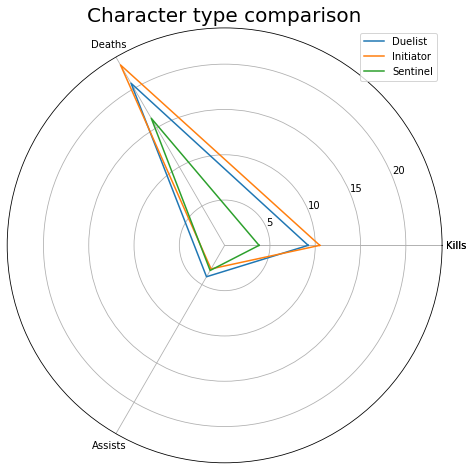

In [179]:
# now create radar chart

categories = ['Kills', 'Deaths', 'Assists']

# + 1 because an error with radar graphs; last point must connect to first
categories = [*categories, categories[0]]

for c_type in avg_dict:
    if c_type in valo_types.keys():
        first_val = avg_dict[c_type][0]
        avg_dict[c_type] = [*avg_dict[c_type], first_val]

label_loc = np.linspace(start=0, stop=2*np.pi, num=len(categories))

plt.figure(figsize=(8,8))
plt.subplot(polar=True)
for c_type in avg_dict:
    if c_type in valo_types.keys():
        plt.plot(label_loc, avg_dict[c_type], label=c_type)
plt.title('Character type comparison', size=20)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

In [180]:
# let's make it look nicer! -- using plotly library

deets = []
for c_type in avg_dict:
    if c_type in valo_types.keys():
        deets.append(
            go.Scatterpolar(r=avg_dict[c_type], theta=categories, fill='toself', name=c_type)
        )
fig = go.Figure(
    data=deets,
    layout=go.Layout(
        title=go.layout.Title(text='Sexi stats'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

pyo.plot(fig)

'temp-plot.html'

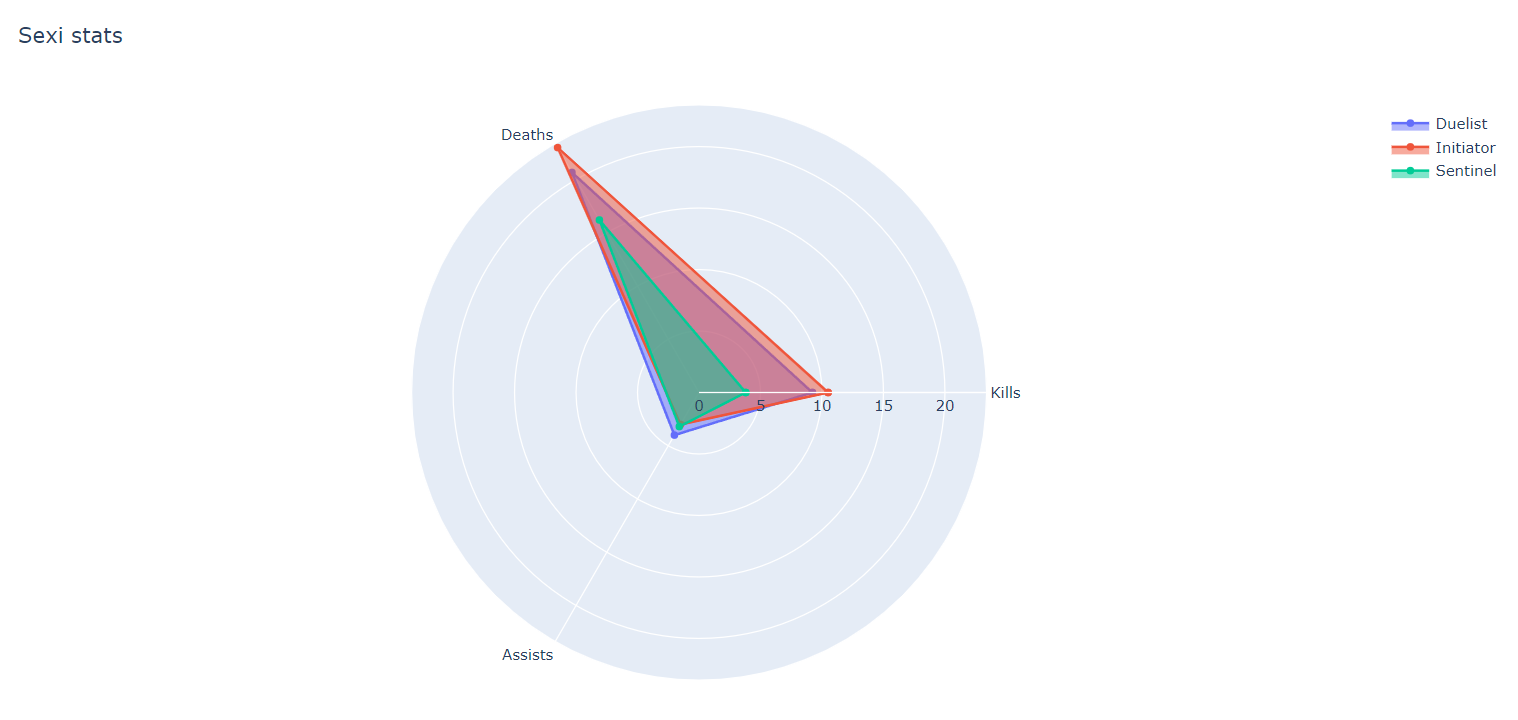

# Finding my best map

In [181]:
# best map; bar graph based off average score per map, its colour hue based on how many wins

#split dfs by map
map_types = {mapname: mapdf for (mapname,mapdf) in df.groupby('Map')}
map_types['Split']

,Character,Map,KDA,K,D,A,Avg,Type,Win,CharType
0,Raze,Split,0.6,4,19,8,133,Custom,F,Duelist
2,Jett,Split,0.6,9,22,5,3262,Custom,F,Duelist
6,Raze,Split,1.1,13,13,1,271,Custom,F,Duelist
9,Raze,Split,0.3,4,21,3,1520,Deathmatch,F,Duelist
15,Sage,Split,0.4,2,14,3,62,Unrated,F,Sentinel


In [182]:
mapdata = pd.DataFrame({
    'Split': [None]*3,
    'Ascent': [None]*3,
    'Bind': [None]*3,
    'Breeze': [None]*3,
    'Fracture': [None]*3,
    'Haven': [None]*3,
    'Icebox': [None]*3,
    'Pearl': [None]*3,
    },
    index=['Kills', 'Deaths', 'Assists']
)

for map_name in mapdata:
    if map_name in map_types:
        mapdata[map_name] = [map_types[map_name]['K'].mean(),map_types[map_name]['D'].mean(),map_types[map_name]['A'].mean()]

In [183]:
# drop all NaN values
mapdata.dropna(axis=1, how='all')

,Split,Ascent,Fracture,Haven,Icebox
Kills,6.4,5.333333,5.0,9.5,17.5
Deaths,17.8,24.333333,17.0,23.5,17.5
Assists,4.0,2.666667,4.0,5.0,3.5


Text(0, 0.5, 'KDA')

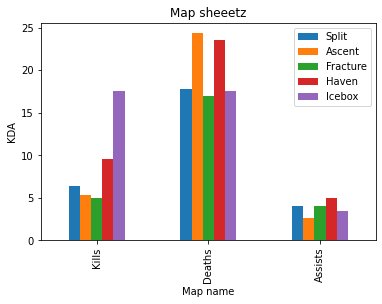

In [184]:
mapdata.plot(kind='bar')
plt.title("Map sheeetz")
plt.xlabel("Map name")
plt.ylabel("KDA")

Text(0, 0.5, 'KDA')

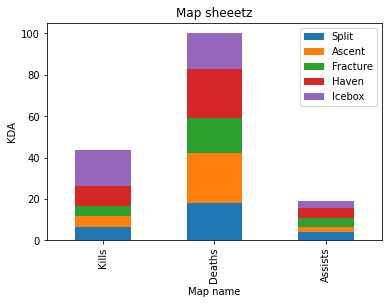

In [185]:
mapdata.plot(kind='bar', stacked=True)
plt.title("Map sheeetz")
plt.xlabel("Map name")
plt.ylabel("KDA")

Icebox is my best map because I get ok deaths, I pop off on kills and assists on all maps are kind of similar anyway.

# Tournament data

# Web scraper

In [186]:
url = "https://www.vlr.gg/event/stats/1015/valorant-champions-2022"
html = urlopen(url)

soup = BeautifulSoup(html, 'lxml')
type(soup)

bs4.BeautifulSoup

In [187]:
rows = soup.find_all('tr')

In [188]:
# convert all rows into a dataframe

for row in rows:
    row_td = row.find_all('td')
print(row_td)

[<td class="mod-player mod-a">
<a href="/player/4874/berserx" style="display: flex; align-items: center; padding-right: 0;">
<i class="flag mod-id" style="min-width: 16px;"></i>
<div style="margin-left: 5px; line-height: 1.2; ">
<div class="text-of" style="font-weight: 700; margin-bottom: 2px; width: 90px;">BerserX</div>
<div class="stats-player-country">BME</div>
</div>
</a>
</td>, <td class="mod-agents">
<div>
<img class="mod-small" src="/img/vlr/game/agents/jett.png"/>
<img class="mod-small" src="/img/vlr/game/agents/skye.png"/>
<img class="mod-small" src="/img/vlr/game/agents/neon.png"/>
</div>
</td>, <td class="mod-rnd">131</td>, <td class="mod-color-sq"><div class="color-sq" style="background: hsl(0,50%,78%)"><span>0.66</span></div><div class="color-sq-mask"></div></td>, <td class="mod-color-sq mod-acs"><div class="color-sq" style="background: hsl(49,50%,78%)"><span>155.8</span></div><div class="color-sq-mask"></div></td>, <td class="mod-color-sq"><div class="color-sq" style="bac

In [189]:
str_cells = str(row_td)
cleantext = BeautifulSoup(str_cells, "lxml").get_text()
print(cleantext)

[



BerserX
BME


, 





, 131, 0.66, 155.8, 0.69, 61%, 100.7, 0.55, 0.12, 0.12, 0.19, 18%, , 
															0/6														
							, 

								21							
, 72, 105, 16, 16, 25]


In [190]:
# that got rid of the agents! Want to keep the images too, before just getting all the texts

# use regular expressions to get values after 'src="/img/vlr/game/agents/"'

agents = []
for row in rows:
    cells = row.find_all('td')
    str_cells = str(cells)
    clean = re.compile('<img[^>]*src="/img/vlr/game/agents/([^"]+).png"[^>]*>')
    img = re.findall(clean, str_cells)
    agents.append(img)

In [191]:
# now for every row we read, we also add the images list

list_rows = []

for index, row in enumerate(rows):
    row_td = row.find_all('td')
    str_cells = str(row_td)
    agents_used = agents[index]
    cleantext = BeautifulSoup(str_cells, "lxml").get_text()
    clean_list = cleantext.split(",")
    if len(clean_list) > 1:
        clean_list[1] = str(agents_used)
    for ele_index in range(len(clean_list)):
        clean_list[ele_index] = clean_list[ele_index].replace('\n','').replace('[','').replace(']','').strip()
    if clean_list and clean_list[0] != "":
        list_rows.append(clean_list)

In [192]:
df2 = pd.DataFrame(list_rows)

In [193]:
# column headings

col_labels = soup.find_all('th')

all_headers = []
col_str = str(col_labels)
cleantext2 = BeautifulSoup(col_str, 'lxml').get_text().replace('[','').replace(']','')
all_headers.append(cleantext2)
print(all_headers)


['Player, Agents, Rnd, R, ACS, K:D, KAST, ADR, KPR, APR, FKPR, FDPR, HS%, CL%, CL, KMax, K, D, A, FK, FD']


In [194]:
# merge the two dataframes together now

all_headers = ['Player', 'Agents', 'Rnd', 'R', 'ACS', 'K:D', 'KAST', 
               'ADR', 'KPR', 'APR', 'FKPR', 'FDPR', 'HS%', 'CL%', 'CL', 
               'KMax', 'K', 'D', 'A', 'FK', 'FD']

In [195]:
df3 = df2.copy()
df3.set_axis(all_headers,axis=1,inplace=True)
df3.head(10)

,Player,Agents,Rnd,R,ACS,K:D,KAST,ADR,KPR,APR,...,FDPR,HS%,CL%,CL,KMax,K,D,A,FK,FD
0,yayOPTC,"'chamber', 'jett'",492,1.26,254.6,1.50,73%,159.8,0.93,0.09,...,0.08,26%,15%,9/59,30,460,306,42,96,40
1,kiNggLEV,"'raze', 'kayo', 'viper'",179,1.26,260.0,1.36,77%,160.9,0.89,0.30,...,0.12,23%,11%,2/18,26,159,117,53,42,21
2,LazZETA,"'kayo', 'chamber', 'skye'",148,1.23,245.0,1.31,71%,156.1,0.86,0.21,...,0.09,28%,20%,6/30,25,128,98,31,22,14
3,pANcadaLOUD,"'omen', 'viper', 'astra'",366,1.21,210.5,1.25,78%,137.5,0.76,0.39,...,0.04,34%,15%,6/41,21,277,221,143,29,16
4,DerkeFNC,"'chamber', 'jett'",319,1.20,247.9,1.39,70%,166.2,0.92,0.13,...,0.15,34%,21%,5/24,31,292,210,42,53,47
5,ShaoFPX,"'sage', 'fade', 'sova'",357,1.15,194.5,1.12,80%,133.7,0.68,0.43,...,0.04,30%,16%,9/56,28,242,216,155,14,15
6,CryocellsXSET,"'chamber', 'jett'",285,1.15,232.2,1.27,71%,143.4,0.85,0.13,...,0.13,24%,19%,8/42,26,242,191,36,50,36
7,SacyLOUD,"'sova', 'fade'",366,1.14,194.0,1.14,77%,127.5,0.68,0.41,...,0.05,25%,12%,5/42,32,248,217,151,27,17
8,MaKoDRX,"'astra', 'omen', 'viper'",416,1.13,207.8,1.14,78%,135.9,0.72,0.43,...,0.07,29%,14%,9/63,28,300,263,179,29,28
9,LessLOUD,"'killjoy', 'chamber', 'cypher'",366,1.13,219.9,1.31,71%,142.6,0.81,0.17,...,0.10,25%,21%,7/34,27,295,226,63,37,37


In [196]:
df4 = df3.copy()
df4['Agents'] = df3['Agents'].apply(lambda x:x.split(","))
df4

,Player,Agents,Rnd,R,ACS,K:D,KAST,ADR,KPR,APR,...,FDPR,HS%,CL%,CL,KMax,K,D,A,FK,FD
0,yayOPTC,"['chamber', 'jett']",492,1.26,254.6,1.50,73%,159.8,0.93,0.09,...,0.08,26%,15%,9/59,30,460,306,42,96,40
1,kiNggLEV,"['raze', 'kayo', 'viper']",179,1.26,260.0,1.36,77%,160.9,0.89,0.30,...,0.12,23%,11%,2/18,26,159,117,53,42,21
2,LazZETA,"['kayo', 'chamber', 'skye']",148,1.23,245.0,1.31,71%,156.1,0.86,0.21,...,0.09,28%,20%,6/30,25,128,98,31,22,14
3,pANcadaLOUD,"['omen', 'viper', 'astra']",366,1.21,210.5,1.25,78%,137.5,0.76,0.39,...,0.04,34%,15%,6/41,21,277,221,143,29,16
4,DerkeFNC,"['chamber', 'jett']",319,1.20,247.9,1.39,70%,166.2,0.92,0.13,...,0.15,34%,21%,5/24,31,292,210,42,53,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,ANGE1FPX,"['fade', 'brimstone', 'omen']",357,0.75,159.6,0.68,65%,106.5,0.53,0.28,...,0.15,31%,10%,2/21,18,189,276,99,27,53
77,MazinFUR,"['kayo', 'breach', 'jett']",113,0.72,146.4,0.70,62%,108.3,0.54,0.35,...,0.19,27%,7%,1/15,28,61,87,39,4,21
78,crowZETA,"['fade', 'breach', 'skye']",148,0.72,136.9,0.66,67%,95.6,0.47,0.32,...,0.05,29%,14%,2/14,14,69,105,48,5,8
79,SurfXIA,"['chamber', 'jett']",103,0.71,175.6,0.77,55%,117.4,0.61,0.12,...,0.23,25%,,0/8,17,63,82,12,12,24


In [197]:
df5 = df4.explode('Agents').reset_index(drop=True)
df5['Agents'] = df5['Agents'].apply(lambda x:x.replace("'","").strip())
df5

,Player,Agents,Rnd,R,ACS,K:D,KAST,ADR,KPR,APR,...,FDPR,HS%,CL%,CL,KMax,K,D,A,FK,FD
0,yayOPTC,chamber,492,1.26,254.6,1.50,73%,159.8,0.93,0.09,...,0.08,26%,15%,9/59,30,460,306,42,96,40
1,yayOPTC,jett,492,1.26,254.6,1.50,73%,159.8,0.93,0.09,...,0.08,26%,15%,9/59,30,460,306,42,96,40
2,kiNggLEV,raze,179,1.26,260.0,1.36,77%,160.9,0.89,0.30,...,0.12,23%,11%,2/18,26,159,117,53,42,21
3,kiNggLEV,kayo,179,1.26,260.0,1.36,77%,160.9,0.89,0.30,...,0.12,23%,11%,2/18,26,159,117,53,42,21
4,kiNggLEV,viper,179,1.26,260.0,1.36,77%,160.9,0.89,0.30,...,0.12,23%,11%,2/18,26,159,117,53,42,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,SurfXIA,chamber,103,0.71,175.6,0.77,55%,117.4,0.61,0.12,...,0.23,25%,,0/8,17,63,82,12,12,24
221,SurfXIA,jett,103,0.71,175.6,0.77,55%,117.4,0.61,0.12,...,0.23,25%,,0/8,17,63,82,12,12,24
222,BerserXBME,jett,131,0.66,155.8,0.69,61%,100.7,0.55,0.12,...,0.19,18%,,0/6,21,72,105,16,16,25
223,BerserXBME,skye,131,0.66,155.8,0.69,61%,100.7,0.55,0.12,...,0.19,18%,,0/6,21,72,105,16,16,25


# I want least deaths!

In [198]:
df5['D'].dtypes

dtype('O')

In [199]:
df5['D'] = df5['D'].astype(int)
df5['D'].dtypes

dtype('int32')

In [200]:
chars = {k: v for (k,v) in df5.groupby('Agents')}

In [201]:
# find mean of all deaths 
charname = []
deaths = []
for char_name in chars:
    charname.append(char_name)
    deaths.append(chars[char_name]['D'].mean())

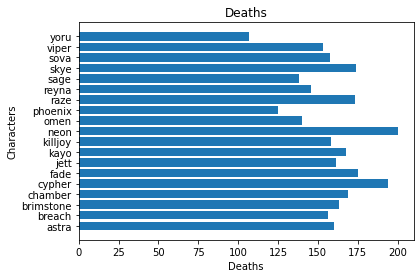

In [202]:
plt.barh(charname, deaths)
plt.title("Deaths")
plt.ylabel("Characters")
plt.xlabel("Deaths")
plt.show()

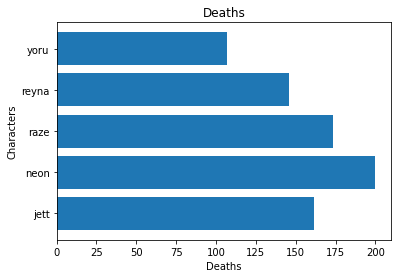

In [203]:
# for duelists
charname = []
deaths = []
for char_name in chars:
    if char_name.capitalize() in character_map['Duelist']:
        charname.append(char_name)
        deaths.append(chars[char_name]['D'].mean())

plt.barh(charname, deaths)
plt.title("Deaths")
plt.ylabel("Characters")
plt.xlabel("Deaths")
plt.show()

# Icebox is best my best map, let's get data there

In [204]:
icebox_ranks = [(2,'Neon'), (7,'Reyna'), (8, 'Jett'), (12,'Raze'), (18,'Yoru')] #from Blitz.gg

# using my own death ranking calculations from above...
deathranks = []
for i in range(len(charname)):
    deathranks.append((deaths[i],charname[i].capitalize()))
deathranks.sort()
deathranks

[(107.0, 'Yoru'),
 (146.0, 'Reyna'),
 (161.53333333333333, 'Jett'),
 (173.5, 'Raze'),
 (200.0, 'Neon')]

In [205]:
# now finally get their final ranks, by adding their ranks together.
# we use indexes, e.g. yoru rank 0, reyna rank 1, jett rank 2 etc

#turn the icebox rank into a dictionary so easier to deal with
icebox_dict = {}
for rank, name in icebox_ranks:
    icebox_dict[name] = rank

new_ranks = []
for j in range(len(deathranks)):
    char = deathranks[j][1]
    new_ranks.append((j+icebox_dict[char],char))
new_ranks.sort()

In [206]:
print(new_ranks)

[(6, 'Neon'), (8, 'Reyna'), (10, 'Jett'), (15, 'Raze'), (18, 'Yoru')]


And so we can conclude that Neon is the agent I should main!

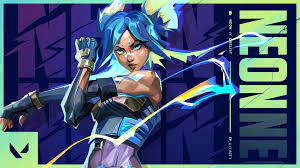